<br>
# Painters Identification using ConvNets
### Marco Tavora
<br>



     
## Index

- [Building Convolutional Neural Networks](#convnets)
    - [Small ConvNets](#smallconvnets)
        - [Imports for Convnets](#importconvnets)
        - [Preprocessing](#keraspreprocessing)
        - [Training the model](#traincnn)
        - [Plotting the results](#plotting)
    - [Transfer learning: Using InceptionV3](#VGG16)
        - [Comments](#comments)
- [References](#ref) 

 <br>
 <br>
                                                                               
                                                                               
                                                                         

In [1]:
print('Created using Python', platform.python_version())

Created using Python 3.6.4


## Introduction

The challenge of recognizing artists given their paintings has been, for a long time, far beyond the capability of algorithms. Recent advances in deep learning, specifically the development of convolutional neural networks, have made that task possible. One of the advantages of these methods is that, in contrast to several methods employed by art specialists, they are not invasive and do not interfere with the painting.


## Overview

I used Convolutional Neural Networks (ConvNets) to identify the artist of a given painting. The dataset contains a minimum of 400 paintings per artist <br> from a set of 37 famous artists. 
<br><br>
I trained a small ConvNet built from scratch, and also used transfer learning, fine-tuning the top layers of a deep pre-trained networks (VGG16).

## Problems with small datasets
The number of training examples in our dataset is small (for image recognition standards). Therefore, making predictions with high accuracy avoiding overfitting becomes a difficult task. To build classification systems with the level of capability of current state-of-the-art models would need millions of training examples. Example of such models are the ImageNet models. Examples of these models include:

- VGG16
- VGG19
- ResNet50
- Inception V3
- Xception



## Preprocessing

The `Keras` class `keras.preprocessing.image.ImageDataGenerator` generates batches of image data with real-time data augmentation and defines the configuration for both image data preparation and image data augmentation. Data augmentation is particularly useful in cases like the present one, where the number of images in the training set is not large, and overfitting can become an issue.

To create an augmented image generator we can follow these steps:

- We must first create an instance i.e. an augmented image generator (using the command below) where several arguments can be chosen. These arguments will determine the alterations to be performed on the images during training:

        datagen = ImageDataGenerator(arguments)

- To use `datagen` to create new images we call the function `fit_generator( )` with the desired arguments.

I will quickly explain some possible arguments of `ImageDataGenerator`:
- `rotation range` defines the amplitude that the images will be rotated randomly during training. Rotations aren't always useful. For example, in the MNIST dataset all images have normalized orientation, so random rotations during training are not needed. In tour present case it is not clear how useful rotations are so I will choose an small argument (instead of just setting it to zero).
- `rotation_range`, `width_shift_range`, `height_shift_range` and `shear_range`: the ranges of random shifts and random shears should be the same in our case, since the images were resized to have the same dimensions.
- I set `fill mode` to be `nearest` which means that pixels that are missing will be filled by the nearest ones.
- `horizontal_flip`: horizontal (and vertical) flips can be useful here since in many examples in our dataset there is no clear definition of orientation (again the MNIST dataset is an example where flipping is not useful)
- We can also standardize pixel values using the `featurewise_center` and `feature_std_normalization` arguments.
***

## Transfer Learning
One way to circunvent this issue is to use 'Transfer Learning', where we use a pre-trained model, modify its final layers and apply to our dataset. When the dataset is too small, these pre-trained models act as feature generators only (see discussion below). As will be illustrated later on, when the dataset in question has some reasonable size, one can drop some layers from the original model, stack a model on top of the network and perform some parameters fine-tuning. 

Before following this approach, I will, in the next section, build a small ConvNet "from scratch". 

In [71]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential  
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
from keras import applications
from keras.applications.imagenet_utils import preprocess_input
from imagenet_utils import decode_predictions
import math, cv2 

folder_train = './train_toy_3/'
folder_test = './test_toy_3/'

In [3]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale = 1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [4]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
K.image_data_format()  # this means that "backend": "tensorflow". Channels are RGB
from keras import applications  
from keras.utils.np_utils import to_categorical  
import math, cv2  

'channels_last'

## Defining the new size of the image

- The images from Wikiart.org had a extremely large size, I wrote a simple function `preprocess( )` (see the notebook about data analysis in this repo) to resize the images. In the next cell I resize them again and play with the size to see how it impacts accuracy. 
- The reason why cropping the image is partly justified is that I believe, the style of the artist is present everywhere in the painting, so cropping shouldn't cause major problems.

In [5]:
img_width, img_height = 120,120

In [6]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
    print('Theano Backend')
else:
    input_shape = (img_width, img_height, 3)
    print('TensorFlow Backend')
    
input_shape

TensorFlow Backend


(120, 120, 3)

In [7]:
nb_train_samples = 0
for p in range(len(os.listdir(os.path.abspath(folder_train)))):
    nb_train_samples += len(os.listdir(os.path.abspath(folder_train) +'/'+ os.listdir(
                                os.path.abspath(folder_train))[p]))
nb_train_samples

nb_test_samples = 0
for p in range(len(os.listdir(os.path.abspath(folder_test)))):
    nb_test_samples += len(os.listdir(os.path.abspath(folder_test) +'/'+ os.listdir(
                                os.path.abspath(folder_test))[p]))
nb_test_samples

1141

359

## Batches and Epochs:

- Batch: a set of $N$ samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model (extracted from the docs).
- Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation. When using `evaluation_data` or `evaluation_split` with the `fit` method of Keras models, evaluation will be run at the end of every epoch (extracted from the docs).
- Larger batch sizes:faster progress in training, but don't always converge as fast. 
- Smaller batch sizes: train slower, but can converge faster. It's definitely problem dependent.

In [8]:
train_data_dir = os.path.abspath(folder_train) # folder containing training set already subdivided
validation_data_dir = os.path.abspath(folder_test) # folder containing test set already subdivided
nb_train_samples = nb_train_samples
nb_validation_samples = nb_test_samples
epochs = 100
batch_size = 16   # batch_size = 16
num_classes = len(os.listdir(os.path.abspath(folder_train)))
print('The painters are',os.listdir(os.path.abspath(folder_train)))

The painters are ['Pablo_Picasso', 'Pierre-Auguste_Renoir', 'Rembrandt']


### Class for early stopping

Model stops training when 10 epochs do not show gain in accuracy.

In [9]:
# rdcolema
class EarlyStoppingByLossVal(Callback):
    """Custom class to set a val loss target for early stopping"""
    def __init__(self, monitor='val_loss', value=0.45, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto') #

In [10]:
top_model_weights_path = 'bottleneck_fc_model.h5'  

### Creating InceptionV3 model

We now create the InceptionV3 model without the final fully-connected layers (setting `include_top=False`) and loading the ImageNet weights (by setting `weights ='imagenet`)

In [11]:
from keras.applications.inception_v3 import InceptionV3
model = applications.InceptionV3(include_top=False, weights='imagenet')  

In [48]:
applications.InceptionV3(include_top=False, weights='imagenet').summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [49]:
type(applications.InceptionV3(include_top=False, weights='imagenet').summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

NoneType

### Training and running images on InceptionV3

We first create the generator. The generator is an iterator that generates batches of images when requested using e.g. `flow( )`.

In [12]:
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False) 
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
print('Number of training samples:',nb_train_samples)
print('Number of classes:',num_classes)

Found 1141 images belonging to 3 classes.
Number of training samples: 1141
Number of classes: 3


### Bottleneck features

The extracted features, which are the last activation maps before the fully-connected layers in the pre-trained model, are called "bottleneck features". The function `predict_generator( )` generates predictions for the input samples from a data generator.

In [13]:
bottleneck_features_train = model.predict_generator(generator, predict_size_train)  # these are numpy arrays

In [14]:
bottleneck_features_train[0].shape
bottleneck_features_train.shape

(2, 2, 2048)

(1141, 2, 2, 2048)

In the next cell, we save the bottleneck features to help training our data:

In [15]:
np.save('bottleneck_features_train.npy', bottleneck_features_train)  

Using `predict( )` we see that, indeed, `ResNet50` is able to identify some objects in the painting. The function `decode_predictions` decodes the results into a list of tuples of the form (class, description, probability). We see below that the model identifies the house in the image as a castle or mosque and shows correctly a non-zero probability of finding a seashore in the painting. In this case, `ResNet50` acts as a feature generator.

Repeating the steps for the validation data:

In [16]:
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
print('Number of testing samples:',nb_validation_samples)

Found 359 images belonging to 3 classes.
Number of testing samples: 359


In [17]:
bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 

### Training the fully-connected network (the top-model)

We now load the features just obtained, get the class labels for the training set and convert the latter into categorial vectors:

In [18]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  

Found 1141 images belonging to 3 classes.


Loading the features:

In [19]:
train_data = np.load('bottleneck_features_train.npy') 

Converting training data into vectors of categories:

In [20]:
train_labels = generator_top.classes  
print('Classes before dummification:',train_labels)  
train_labels = to_categorical(train_labels, num_classes=num_classes) 
print('Classes after dummification:\n\n',train_labels)  

Classes before dummification: [0 0 0 ... 2 2 2]
Classes after dummification:

 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


Again repeating the process with the validation data:

In [21]:
generator_top = datagen_top.flow_from_directory(
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames) 

Found 359 images belonging to 3 classes.


In [22]:
validation_data = np.load('bottleneck_features_validation.npy')  

In [23]:
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

### Building the small FL model using bottleneck features as input

In [24]:
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:])) 
# model.add(Dense(1024, activation='relu'))  
# model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(32, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(8, activation='relu')) # Not valid for minimum = 500
model.add(Dropout(0.5)) 
# model.add(Dense(4, activation='relu')) # Not valid for minimum = 500
# model.add(Dropout(0.5)) 
model.add(Dense(num_classes, activation='sigmoid'))  
   
model.compile(optimizer='Adam',  
              loss='binary_crossentropy', metrics=['accuracy'])   
   
history = model.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))  
   
model.save_weights(top_model_weights_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(
    validation_data, validation_labels, 
    batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  

Train on 1141 samples, validate on 359 samples
Epoch 1/100
1141/1141 [==============================] - 11s 9ms/step - loss: 2.0881 - acc: 0.5451 - val_loss: 0.6892 - val_acc: 0.5162
Epoch 2/100
1141/1141 [==============================] - 7s 7ms/step - loss: 1.1520 - acc: 0.5504 - val_loss: 0.6889 - val_acc: 0.5395
Epoch 3/100
1141/1141 [==============================] - 9s 8ms/step - loss: 0.9261 - acc: 0.5828 - val_loss: 0.6833 - val_acc: 0.6667
Epoch 4/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.7618 - acc: 0.6377 - val_loss: 0.6764 - val_acc: 0.6667
Epoch 5/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.7100 - acc: 0.6506 - val_loss: 0.6688 - val_acc: 0.6667
Epoch 6/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.6894 - acc: 0.6564 - val_loss: 0.6629 - val_acc: 0.6667
Epoch 7/100
1141/1141 [==============================] - 7s 6ms/step - loss: 0.6817 - acc: 0.6564 - val_loss: 0.6582 - val_acc: 0.6667
Epoch 8

Epoch 61/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.4850 - acc: 0.7444 - val_loss: 0.4959 - val_acc: 0.7586
Epoch 62/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.4797 - acc: 0.7543 - val_loss: 0.5178 - val_acc: 0.7549
Epoch 63/100
1141/1141 [==============================] - 7s 6ms/step - loss: 0.4812 - acc: 0.7523 - val_loss: 0.5022 - val_acc: 0.7493
Epoch 64/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.4847 - acc: 0.7502 - val_loss: 0.5773 - val_acc: 0.7642
Epoch 65/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.4638 - acc: 0.7584 - val_loss: 0.5520 - val_acc: 0.7577
Epoch 66/100
1141/1141 [==============================] - 7s 6ms/step - loss: 0.4509 - acc: 0.7680 - val_loss: 0.5132 - val_acc: 0.7474
Epoch 67/100
1141/1141 [==============================] - 8s 7ms/step - loss: 0.4727 - acc: 0.7572 - val_loss: 0.5313 - val_acc: 0.7549
Epoch 68/100
1141/1141 [========================

In [25]:
train_data.shape[1:]

(2, 2, 2048)

In [26]:
# model.evaluate(  
#      validation_data, validation_labels, batch_size=batch_size, verbose=1) 

In [27]:
# model.predict_classes(validation_data)

In [28]:
# model.metrics_names

In [29]:
#top_k_categorical_accuracy(y_true, y_pred, k=5)

### Plotting the accuracy history

Text(0.5,1,'model accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'epoch')

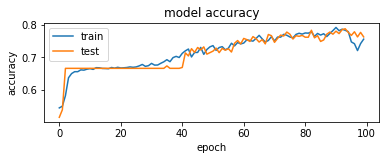

In [32]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
#pylab.ylim([0.4,0.68])
plt.legend(['train', 'test'], loc='upper left')  

### Plotting the loss history

Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

(0, 60)

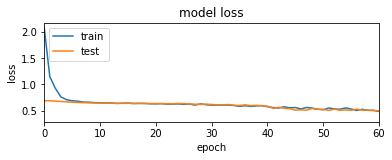

In [34]:
import pylab
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
pylab.xlim([0,60])
# pylab.ylim([0,1000])
plt.show()  

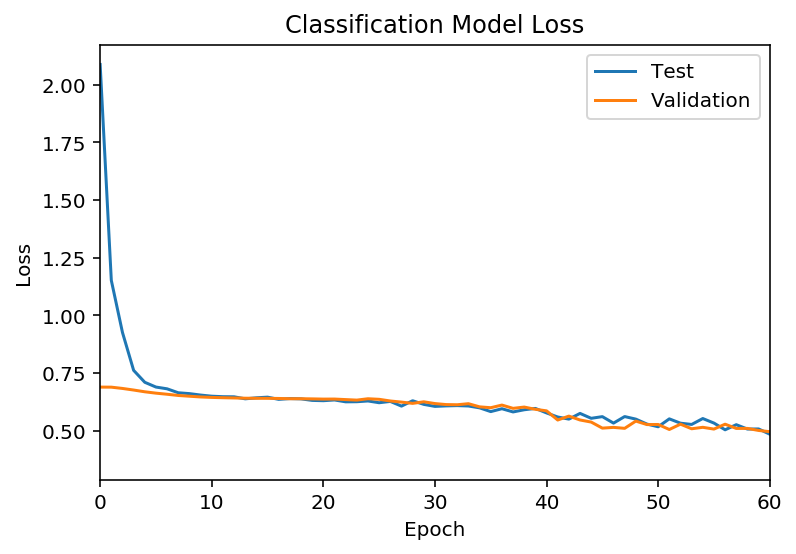

In [45]:
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classification Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
pylab.xlim([0,60])
plt.legend(['Test', 'Validation'], loc='upper right')
fig.savefig('loss.png')
plt.show();

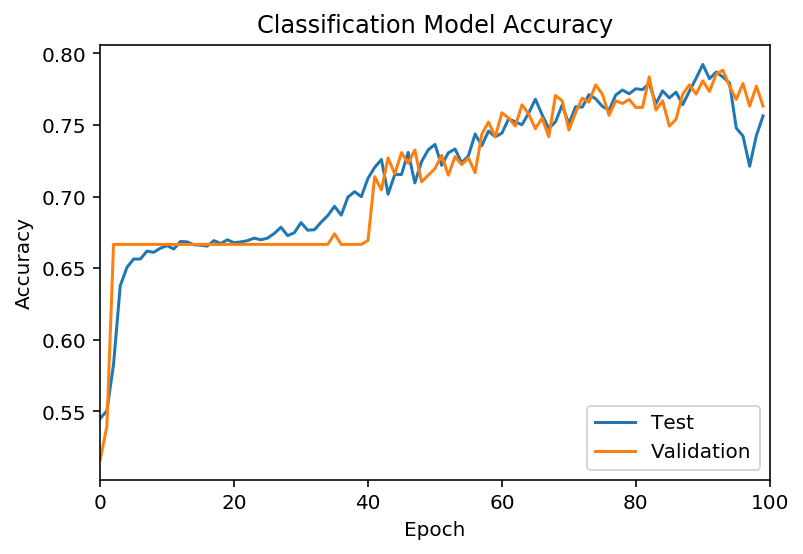

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(figsize=(15,15))
plt.title('Classification Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
pylab.xlim([0,100])
plt.legend(['Test', 'Validation', 'Success Metric'], loc='lower right')
fig.savefig('acc.png')
plt.show();

In [51]:
!pwd

/Users/marcotavora/capstone_phase_2


### Predictions

In [ ]:
os.listdir(os.path.abspath('train_toy_3/Pierre-Auguste_Renoir))

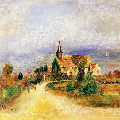

array([[[220., 215., 211.],
        [207., 202., 198.],
        [184., 179., 175.],
        ...,
        [218., 205., 199.],
        [221., 206., 211.],
        [229., 212., 228.]],

       [[207., 202., 198.],
        [208., 203., 199.],
        [214., 209., 205.],
        ...,
        [201., 188., 180.],
        [197., 182., 185.],
        [204., 188., 198.]],

       [[218., 213., 209.],
        [208., 203., 199.],
        [207., 202., 198.],
        ...,
        [210., 200., 190.],
        [209., 198., 194.],
        [223., 211., 213.]],

       ...,

       [[237., 215.,  95.],
        [239., 219.,  98.],
        [248., 227., 108.],
        ...,
        [253., 217., 131.],
        [242., 206., 118.],
        [219., 182.,  94.]],

       [[246., 223., 111.],
        [250., 228., 116.],
        [244., 222., 110.],
        ...,
        [232., 195., 106.],
        [237., 200., 111.],
        [233., 194., 103.]],

       [[240., 214., 117.],
        [243., 219., 121.],
        [244., 2

In [75]:
image_path = os.path.abspath('test_toy_3/Pierre-Auguste_Renoir/91485.jpg')
orig = cv2.imread(image_path) 
image = load_img(image_path, target_size=(120,120))  
image
image = img_to_array(image)  
image

In [76]:
image = image / 255.  
image = np.expand_dims(image, axis=0)  
image

array([[[[0.8627451 , 0.84313726, 0.827451  ],
         [0.8117647 , 0.7921569 , 0.7764706 ],
         [0.72156864, 0.7019608 , 0.6862745 ],
         ...,
         [0.85490197, 0.8039216 , 0.78039217],
         [0.8666667 , 0.80784315, 0.827451  ],
         [0.8980392 , 0.83137256, 0.89411765]],

        [[0.8117647 , 0.7921569 , 0.7764706 ],
         [0.8156863 , 0.79607844, 0.78039217],
         [0.8392157 , 0.81960785, 0.8039216 ],
         ...,
         [0.7882353 , 0.7372549 , 0.7058824 ],
         [0.77254903, 0.7137255 , 0.7254902 ],
         [0.8       , 0.7372549 , 0.7764706 ]],

        [[0.85490197, 0.8352941 , 0.81960785],
         [0.8156863 , 0.79607844, 0.78039217],
         [0.8117647 , 0.7921569 , 0.7764706 ],
         ...,
         [0.8235294 , 0.78431374, 0.74509805],
         [0.81960785, 0.7764706 , 0.7607843 ],
         [0.8745098 , 0.827451  , 0.8352941 ]],

        ...,

        [[0.92941177, 0.84313726, 0.37254903],
         [0.9372549 , 0.85882354, 0.38431373]

In [ ]:
# build the VGG16 network  
#model = applications.VGG16(include_top=False, weights='imagenet')  
model = applications.InceptionV3(include_top=False, weights='imagenet')   
# get the bottleneck prediction from the pre-trained VGG16 model  
bottleneck_prediction = model.predict(image)

In [81]:
# build top model  
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:])) 
# model.add(Dense(1024, activation='relu'))  
# model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(32, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(8, activation='relu')) # Not valid for minimum = 500
model.add(Dropout(0.5)) 
# model.add(Dense(4, activation='relu')) # Not valid for minimum = 500
# model.add(Dropout(0.5)) 
model.add(Dense(num_classes, activation='sigmoid')) 

In [82]:
model.load_weights(top_model_weights_path)  
   
# use the bottleneck prediction on the top model to get the final classification  
class_predicted = model.predict_classes(bottleneck_prediction)

In [ ]:
inID = class_predicted[0]  
   
class_dictionary = generator_top.class_indices  
   
inv_map = {v: k for k, v in class_dictionary.items()}  
   
label = inv_map[inID]  
   
# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  
   
# display the predictions with the image  
cv2.putText(orig, "Predicted: {}".format(label), (10, 30), cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)  
   
cv2.imshow("Classification", orig)  
cv2.waitKey(0)  
cv2.destroyAllWindows()